<a href="https://colab.research.google.com/github/VietDung/Logistics-Demand-Forecasting-using-ARIMA-and-LSTM/blob/master/EDA_ARMA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import các thư viện cần thiết
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import StandardScaler



df = pd.read_excel('/content/adventure_works.xlsx', sheet_name="Sales")

df = df.drop_duplicates()
# Sử dụng .loc để tránh cảnh báo SettingWithCopyWarning
df = df.loc[:, ['ProductKey', 'OrderDate', 'Quantity']]
df['OrderDate'] = pd.to_datetime(df['OrderDate'], errors='coerce')

# Nhóm dữ liệu theo ProductKey và OrderDate, sau đó tính tổng Quantity
df = df.groupby(['ProductKey', 'OrderDate']).agg({'Quantity': 'sum'}).reset_index()


df = df[df['ProductKey'] == 212][['OrderDate', 'Quantity']]





# Đặt cột 'Date' làm chỉ số cho DataFrame
df.set_index('OrderDate', inplace=True)

# Hiển thị một số hàng đầu của dataframe
print(df.head())
# chia dữ liệu theo tuần
df = df.resample('W').sum()
# Thống kê mô tả
print(df.describe())

# Kiểm tra giá trị thiếu
print(df.isnull().sum())
print(df['Quantity'].dtype)
if df['Quantity'].dtype != 'O':
    df['Quantity'] = df['Quantity'].astype(str)

df['Quantity'] = pd.to_numeric(df['Quantity'].str.replace(r'[^0-9-]', '', regex=True), errors='coerce')

df.columns

# Tính IQR cho cột 'Order_Demand'
Q1 = df['Quantity'].quantile(0.25)
Q3 = df['Quantity'].quantile(0.75)
IQR = Q3 - Q1

# Lọc và thay thế outlier
df['Quantity'] = df['Quantity'].apply(lambda x: max(x, Q1 - 1.5 * IQR) if x < Q1 - 1.5 * IQR else min(x, Q3 + 1.5 * IQR) if x > Q3 + 1.5 * IQR else x)





            Quantity
OrderDate           
2017-07-04         1
2017-07-07         2
2017-07-10         4
2017-07-16         1
2017-07-18         5
        Quantity
count  52.000000
mean   10.846154
std     7.837528
min     0.000000
25%     5.000000
50%     9.000000
75%    14.250000
max    35.000000
Quantity    0
dtype: int64
int64


In [ ]:
print(df.columns)


Index(['Quantity'], dtype='object')


In [ ]:
print(df.dtypes)


Quantity    float64
dtype: object


In [ ]:
df

,Quantity
OrderDate,
2017-07-09,3.000
2017-07-16,5.000
2017-07-23,9.000
2017-07-30,7.000
2017-08-06,2.000
2017-08-13,7.000
2017-08-20,15.000
2017-08-27,25.000
2017-09-03,9.000


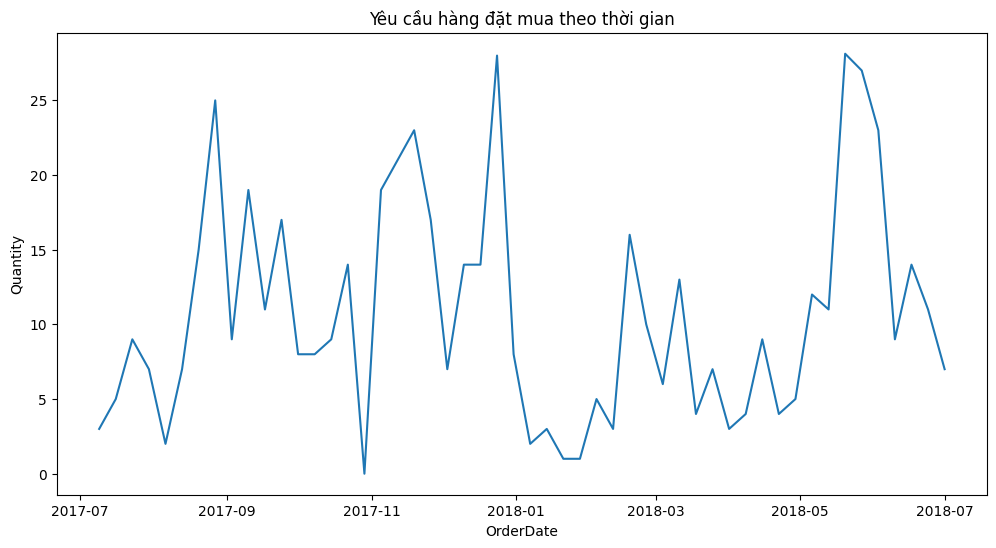

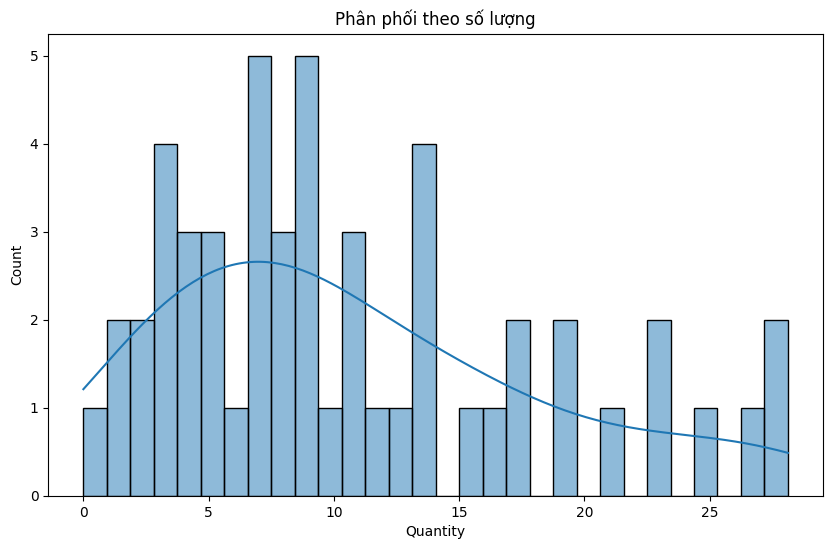

In [ ]:
# EDA - Biểu đồ dạng chuỗi thời gian của Order_Demand
plt.figure(figsize=(12, 6))
sns.lineplot(x='OrderDate', y='Quantity', data=df)
plt.title('Yêu cầu hàng đặt mua theo thời gian')
plt.show()

# EDA - Phân phối của Order_Demand
plt.figure(figsize=(10, 6))
sns.histplot(df['Quantity'], bins=30, kde=True)
plt.title('Phân phối theo số lượng')
plt.show()

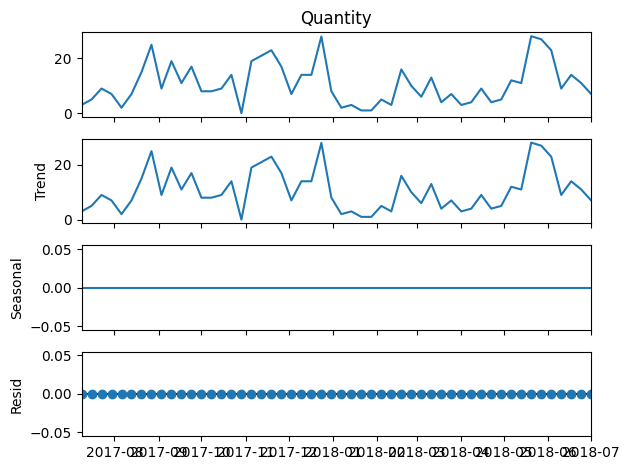

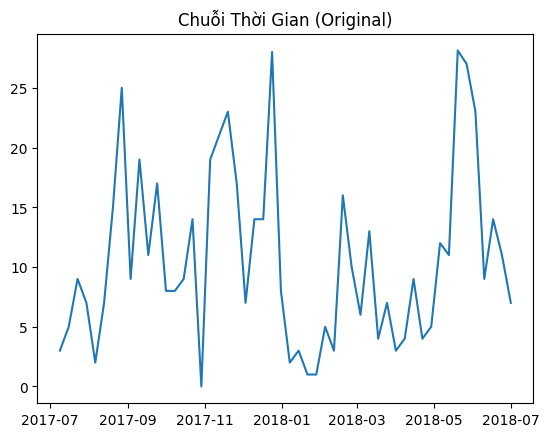

ADF Statistic (After Differencing): -4.5215775141028685
p-value: 0.00017972057090503364
Critical Values: {'1%': -3.5656240522121956, '5%': -2.920142229157715, '10%': -2.598014675124952}
Kết luận: Chuỗi thời gian sau sai phân là dừng


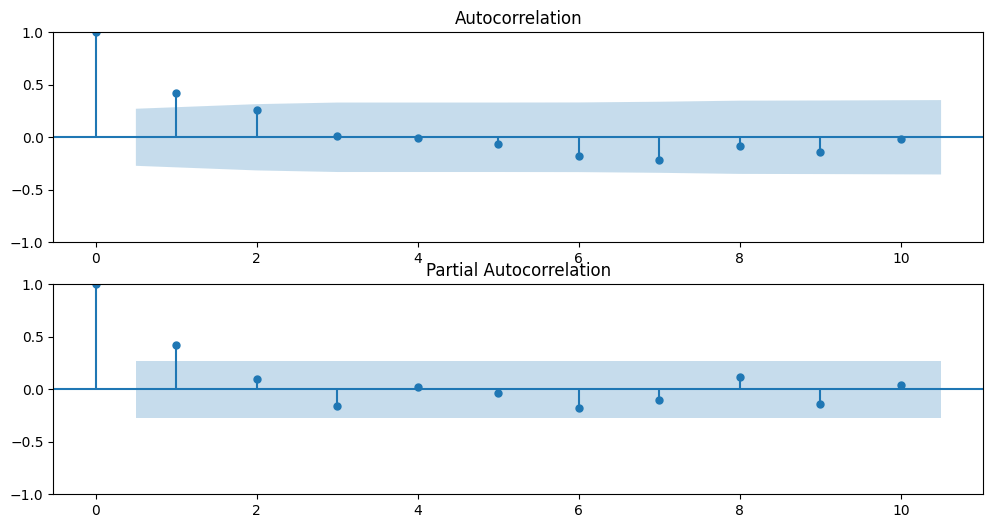

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


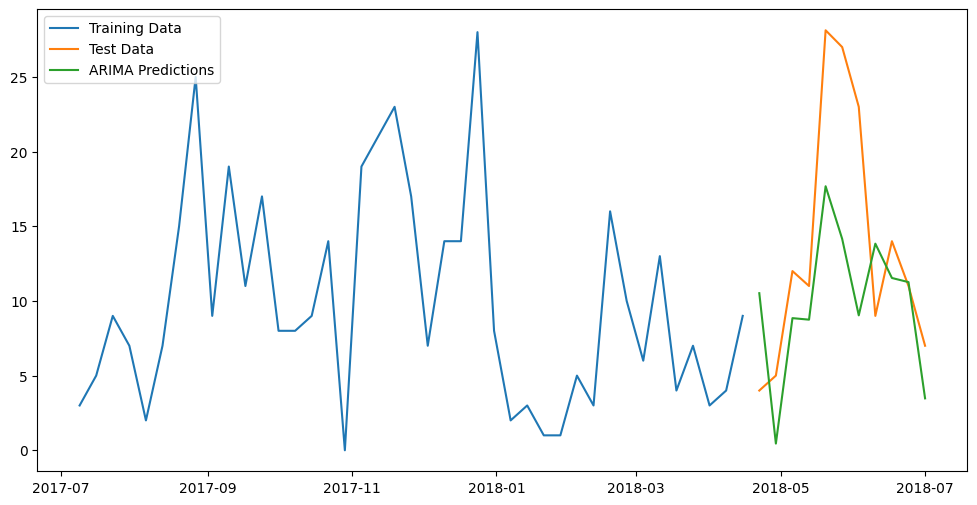

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# EDA - Phân tích chuỗi thời gian
# Phân rã chuỗi thời gian để kiểm tra xu hướng và mùa vụ
result = seasonal_decompose(df['Quantity'], model='additive', period=1)


result.plot()
plt.show()


# Hiển thị biểu đồ chuỗi thời gian
plt.plot(df['Quantity'])
plt.title('Chuỗi Thời Gian (Original)')
plt.show()




from statsmodels.tsa.stattools import adfuller

result_diff = adfuller(df['Quantity'].dropna())

# In kết quả kiểm định sau sai phân
print('ADF Statistic (After Differencing):', result_diff[0])
print('p-value:', result_diff[1])
print('Critical Values:', result_diff[4])

# Kiểm tra kết quả và đưa ra kết luận về tính dừng
if result_diff[1] <= 0.05:
    print("Kết luận: Chuỗi thời gian sau sai phân là dừng")
else:
    print("Kết luận: Chuỗi thời gian sau sai phân không phải là dừng")


# EDA - Kiểm tra hàm tương quan tự hồi quy (ACF) và hàm tương quan riêng (PACF)
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plot_acf(df['Quantity'], lags=10, ax=plt.gca())
plt.subplot(2, 1, 2)
plot_pacf(df['Quantity'], lags=10, ax=plt.gca())
plt.show()

from statsmodels.tsa.arima.model import ARIMA

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
train_size = int(len(df) * 0.8)
train, test = df['Quantity'][:train_size], df['Quantity'][train_size:]

# Xây dựng mô hình ARIMA
model = ARIMA(train, order=(12, 0, 6))  # Điều chỉnh order dựa trên ACF và PACF
fit_model = model.fit()

# Dự báo trên tập kiểm tra
predictions = fit_model.forecast(steps=len(test))

# So sánh dự báo với thực tế
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(predictions, label='ARIMA Predictions')
plt.legend()
plt.show()



In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np

# Tính MAPE
mape = mean_absolute_error(test, predictions) / np.mean(test) * 100
print('Mean Absolute Percentage Error (MAPE):', mape)


Mean Absolute Percentage Error (MAPE): 36.605987182301945


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
